# Notebook to demo analysis on data from the 2019 FSG Endurance
This notebook shows how to use the InfluxDB time series database to query data, and perform analysis on the data from the 2019 FSG Endurance.

Install the following pip packages before starting:
* influxdb-client
* pandas
* matplotlib
* ciso8601 (Required latest C++ Build Tools installed as well. Not a requirement but improve query performance. Vx query w/ ciso = 4.2s, Vx query wo/ ciso = 2m40s)

## Configuration

In [6]:
from influxdb_client import InfluxDBClient
from matplotlib.dates import DateFormatter

# You can generate an API token from the "API Tokens Tab" in the UI
token = "74iSI77607iR7juwbeHmWLMHI5YwqixApVTVgJAgj8OyoCcSZssZrXQg1SOxk6ejq6k39WD0Attsq16KGjmRrQ=="
org = "Root"
host = "http://localhost:8086"
bucket = "ImportedTelemetry"

# Creating a client and APIs
The InfluxDBClient is your entry point to the InfluxDB APIs, which can be aquired from the client.

In [7]:
with InfluxDBClient(url=host, token=token, org=org) as client:
    query_api = client.query_api()

## Query a set of data
With a query API aquired, we can start to fire of some queries. This is done using the flux language: https://docs.influxdata.com/influxdb/cloud/query-data/get-started/ 

In our first example, we are going to query the longitudinal velocity of Nova during the entire Endurance.

In [12]:
    vx_frame = query_api.query_data_frame('from(bucket: "PlayBucket")'
                                            '|> range(start: 2019-08-11T14:00:00.000Z, stop: 2019-08-11T15:00:00.000Z)'
                                            '|> filter(fn: (r) => r["log"] == "FSG Endurance 2019")'
                                            '|> filter(fn: (r) => r["_measurement"] == "vcu.INS")'
                                            '|> filter(fn: (r) => r["_field"] == "vx")'
                                            '|> rename(columns: {_value: "vx"})')

## Plotting
The data returned from these queries are formatted in pandas dataframes when using the query_data_frame method, so plotting is super easy!

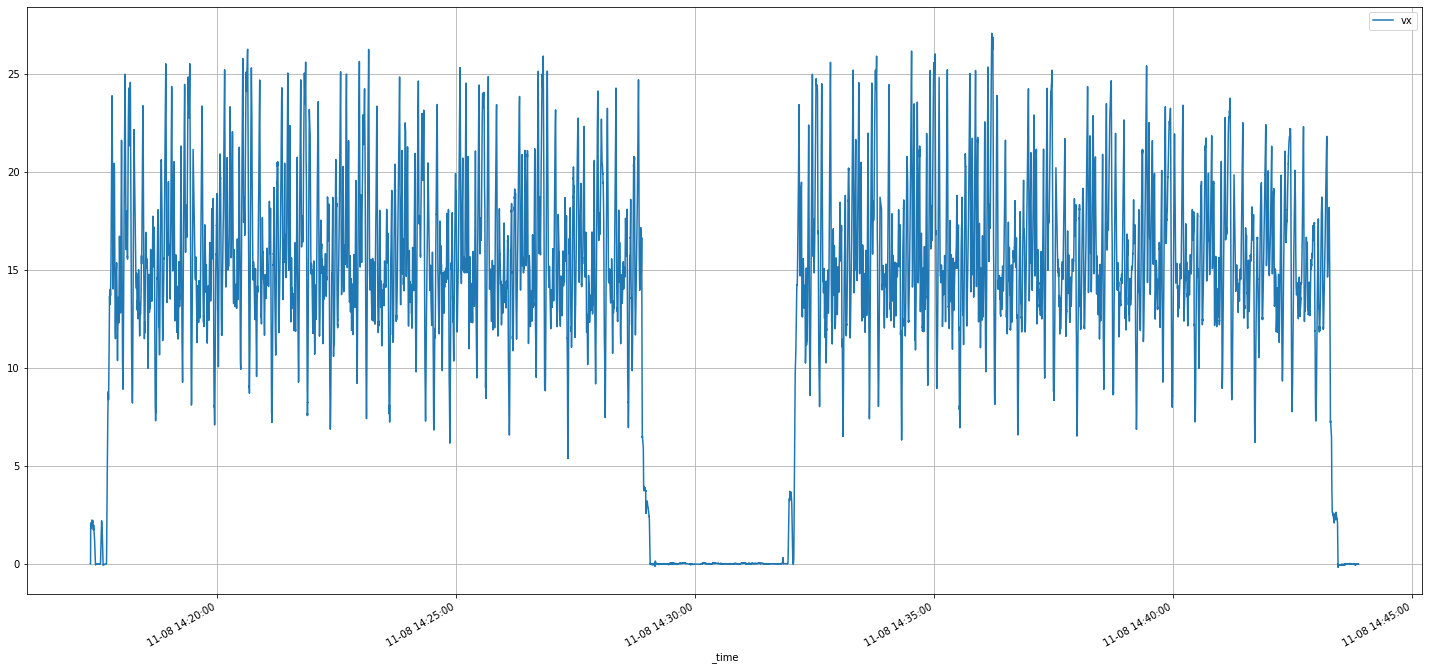

In [9]:
    ax = vx_frame.plot(x="_time", y="vx", figsize=(25, 12), grid=True,)
    ax.xaxis.set_major_formatter(DateFormatter("%d-%m %H:%M:%S"))

## Performs calculations on your data
Using the Flux language and its built in functions, you can directly query metrics based on the data from InfluxDB. For example the average speed per lap.

In [10]:
    data_frame = query_api.query_data_frame('from(bucket: "PlayBucket")'
                                            '|> range(start: 2019-08-11T14:00:00.000Z, stop: 2019-08-11T15:00:00.000Z)'
                                            '|> filter(fn: (r) => r["log"] == "FSG Endurance 2019")'
                                            '|> filter(fn: (r) => r["_measurement"] == "vcu.INS")'
                                            '|> filter(fn: (r) => r["_field"] == "vx")'
                                            '|> group(columns: ["lap"], mode: "by")'
                                            '|> mean(column: "_value")'
                                            '|> drop(columns: ["result", "table", "_start", "_stop"])'
                                            '|> rename(columns: {_value: "avg_vx"})')

    print(data_frame.to_string(columns=["lap", "avg_vx"]))

         lap     avg_vx
0         01  15.573171
1         02  15.772153
2         03  16.028140
3         04  15.955019
4         05  15.999581
5         06  15.413932
6         07  15.793979
7         08  15.848505
8         09  15.606867
9         10  15.691718
10        11  16.057238
11        12  15.831993
12        13  15.911126
13        14  15.750893
14        15  15.957201
15        16  15.784907
16        17  15.702250
17        18  15.357272
18    InPits   0.418308
19  ToGarage   0.849177
20   ToStart   1.465362


## Query with user defined functions
TODO: This is where shit gets real!